In [1]:
import tensorflow as tf
import io
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow you to load the image as gray scale image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import csv
import gc

2024-07-07 13:36:09.853495: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 13:36:09.884355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 13:36:09.884383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 13:36:09.885226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 13:36:09.890444: I tensorflow/core/platform/cpu_feature_guar

In [2]:
!nvidia-smi

Sun Jul  7 13:36:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:65:00.0 Off |                  N/A |
| 66%   53C    P2             134W / 370W |    516MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
file1 = 'LUNA/HF_comorbidities_train.tfrecords'
file2 = 'LUNA/HF_comorbidities_valid.tfrecords'
file3 = 'LUNA/HF_comorbidities_test.tfrecords'
cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

In [4]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[1], device_type='GPU')

In [5]:
raw_dataset = tf.data.TFRecordDataset(file1)
X_train = []
Y_train = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    sub_y.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    for idx in range(12):
        sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])

    X_train.append(sub_x)
    Y_train.append(sub_y)

X_train = np.array(X_train)
X_train = X_train.astype(np.int64)
Y_train = np.array(Y_train)
Y_train = Y_train.astype(np.int64)

2024-07-07 13:36:12.053854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21152 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [6]:
raw_dataset = tf.data.TFRecordDataset(file2)
X_valid = []
Y_valid = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    # Y_valid.append(example.features.feature['Label'].int64_list.value[0])
    sub_y.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    for idx in range(12):
        sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])
    
    X_valid.append(sub_x)
    Y_valid.append(sub_y)

X_valid = np.array(X_valid)
X_valid = X_valid.astype(np.int64)
Y_valid = np.array(Y_valid)
Y_valid = Y_valid.astype(np.int64)

In [7]:
raw_dataset = tf.data.TFRecordDataset(file3)
X_test = []
Y_test = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    Y_test.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    for idx in range(12):
        sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])

    X_test.append(sub_x)
    # Y_test.append(sub_y)

X_test = np.array(X_test)
X_test = X_test.astype(np.int64)
Y_test = np.array(Y_test)
Y_test = Y_test.astype(np.int64)

In [8]:
a=np.array([[1, 2, 3, 4, 5]])
b=[0, 1]
print(a[:, b])

[[1 2]]


In [9]:
X_train=np.vstack([X_train, X_valid])
# print(X_train_resampled.shape)
Y_train=np.vstack([Y_train, Y_valid])
# print(Y_train_resampled.shape)

In [10]:
# from imblearn.over_sampling import SMOTE
# from sklearn.utils import shuffle

# smote = SMOTE(random_state=42)
# selected_features = [0, 1, 2]
# X_smote = X_train[:, selected_features]

# X_smote_resampled, Y_smote_resampled = smote.fit_resample(X_smote, Y_train)
# num_samples = len(X_smote_resampled) - len(X_train)

# # Randomly select matching samples from X_remaining and Y_train
# rng = np.random.default_rng(seed=42)  # Adjust seed as needed
# indices = rng.choice(X_train.shape[0], num_samples, replace=False)

# X_selected = X_train[indices, :]
# Y_selected = Y_train[indices]

# # Combine the resampled columns with the remaining data
# X_combined = np.vstack((X_train, X_selected))
# Y_combined = np.vstack((Y_train, Y_selected))

# X_train_resampled = X_combined
# Y_train_resampled = Y_combined

# # X_train_resampled, Y_train_resampled = shuffle(X_combined, Y_combined, random_state=42)

In [11]:
# # from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# # features_to_resample = [0, 1, 2]
# # print(len(X_train))
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
# X_valid_resampled, Y_valid_resampled = smote.fit_resample(X_valid, Y_valid)
# # X_train_resampled_full = np.zeros((X_train_resampled_features.shape[0], X_train.shape[1]))
# # X_train_resampled_full[:, features_to_resample] = X_train_resampled_features


In [13]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)
X_train_resampled = X_train
Y_train_resampled = Y_train
print(X_train_resampled.shape, Y_train_resampled.shape)
# print(X_valid_resampled.shape, Y_valid_resampled.shape)

(3506, 15) (3506, 1)
(809, 15) (809, 1)
(347, 15) (347,)
(3506, 15) (3506, 1)


In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [15]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

In [16]:
RF_model = RandomForestClassifier(**parameters)
RF_model.fit(X_train_resampled, Y_train_resampled)

/home/jupyter-ryan1211/.conda/envs/test/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=50)

In [17]:
RF_predictions = RF_model.predict(X_test)
score = accuracy_score(Y_test ,RF_predictions)
print(score)

0.6167146974063401


In [18]:
y_pred_prob = RF_model.predict_proba(X_test)[:, 1] 
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_pred_prob) 
roc_auc

0.6811096211867247

Confusion Matrix:
[[ 61  96]
 [ 37 153]]


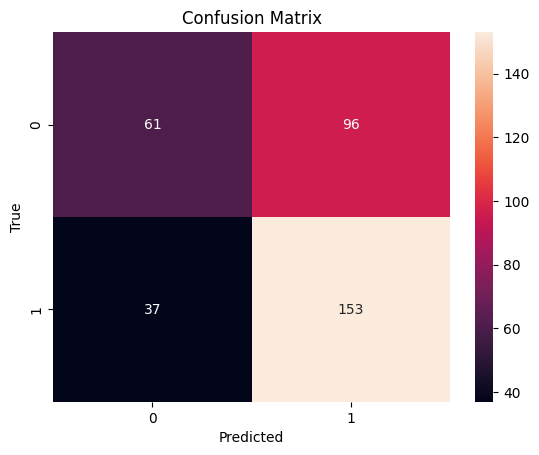

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, RF_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
importances = RF_model.feature_importances_

In [21]:
print(importances)

[0.06940309 0.08566566 0.33582746 0.07410858 0.14014081 0.04424331
 0.02478847 0.04758379 0.03356782 0.03157676 0.02354107 0.01620108
 0.03148059 0.01030935 0.03156217]


In [22]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    random_state=0,
    shuffle=False,
)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_resampled, Y_train_resampled)

/home/jupyter-ryan1211/.conda/envs/test/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=0)

In [23]:
forest_predictions = forest.predict(X_test)
score = accuracy_score(Y_test ,forest_predictions)
print(score)

0.6801152737752162


In [24]:
y_pred_prob = forest.predict_proba(X_test)[:, 1] 
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_pred_prob) 
print(roc_auc)

0.7413342272879652


In [25]:
from Utils import * 

fpr, tpr, threshes =metrics.roc_curve(Y_test, y_pred_prob)
best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
metrics.auc(fpr, tpr)

0.7413342272879652

In [26]:
print(y_pred_prob)

[0.75971489 0.85513456 1.         0.79251234 1.         0.07790043
 0.92887626 0.72381571 0.57459662 0.38857937 1.         0.78481646
 0.74396032 0.99166667 0.59982585 0.37785867 0.4307381  1.
 1.         0.5031535  0.1734131  0.43232937 0.26391905 0.89747619
 0.04       0.92202381 0.9        0.61460029 0.56228571 0.8
 0.99166667 0.59982585 0.18539311 0.40699782 0.01       0.9305
 0.62643285 0.5029612  0.43416667 0.2335873  0.75999867 0.42484416
 0.65409151 0.92963124 0.53829274 0.93       0.50853725 0.41489932
 0.         0.865      0.3676189  0.40950527 0.85513456 0.18602381
 0.5031535  1.         0.43       0.73       0.59695465 0.89095245
 0.49720924 0.         0.55       0.95       0.76456635 1.
 0.62573658 0.98527778 0.45091157 0.59900455 0.41159306 0.40950527
 0.78481646 0.02       0.0525     0.945      1.         0.64703523
 0.1734131  0.         0.32435384 0.1382619  0.07       0.16159524
 0.5150066  0.90512821 0.80277035 0.53384318 1.         0.90062728
 0.977      0.59900455

In [27]:
from joblib import dump, load

dump(forest, 'random_forest_model_plus.joblib')

# loaded_model = load('random_forest_model.joblib')

['random_forest_model_plus.joblib']

Confusion Matrix:
[[ 87  70]
 [ 41 149]]


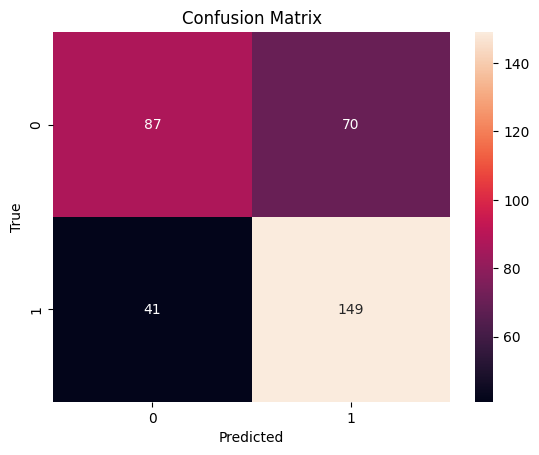

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, forest_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
importances = forest.feature_importances_

In [30]:
print(importances)

[0.14999078 0.12893939 0.11773261 0.06014634 0.06625303 0.05590733
 0.05371033 0.08426688 0.07704985 0.04880761 0.0409815  0.01326735
 0.02173781 0.01081972 0.07038947]


In [31]:
forest_test = forest.predict_proba(X_test)

In [32]:
# positive_class_probabilities = forest_test[:, 1]

In [33]:
# positive_class_probabilities

In [34]:
# with tf.device('/cpu:0'):

#     filename = "LUNA/HF_comorbidities_test.tfrecords"
    
#     raw_dataset = tf.data.TFRecordDataset(filename)
#     X_train = []
#     Y_train = []
#     i=0
#     for raw_record in raw_dataset:
#         sub_y = []
    
#         example = tf.train.Example()
#         example.ParseFromString(raw_record.numpy())
    
#         nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
#         # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
#         img_np = cv.imdecode(nparr, cv.IMREAD_COLOR)
#         # img_np = cv.imdecode(nparr, cv.COLOR_BGR2RGB)
#         X_train.append(img_np)
#         # Y_train.append(sub_y)
    
#         # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
#         # plt.imshow(img_np, cmap='gray')
#         # plt.show()
    
#     X_train = np.array(X_train)
#     # Y_train = np.array(Y_train)
#     X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],-1)
#     # Y_train = Y_train.astype(np.float64)
#     # print(Y_train.shape)

In [36]:
# X_train.shape